In [29]:
from path import Path
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Exploración básica

In [2]:
path = Path('../input/ashrae-energy-prediction')

In [3]:
! ls {path}

building_metadata.csv  kernels		      test.csv	 weather_test.csv
input		       sample_submission.csv  train.csv  weather_train.csv


### Datos de entrenamiento

In [4]:
train_df      = pd.read_csv(path/'train.csv')
train_weather = pd.read_csv(path/"weather_train.csv")

### Datos de test

In [41]:
test_df       = pd.read_csv(path/'test.csv')
test_weather  = pd.read_csv(path/"weather_test.csv")

### Edificios

In [42]:
building_df   = pd.read_csv(path/'building_metadata.csv')

### ¿Qué hay en los CSVs?

In [43]:
display(train_df.head())
display( test_df.head())

display(train_weather.head())
display( test_weather.head())

display(building_df.head())

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


### ¿Hay NaNs? ¿Faltan datos?

In [57]:
def check_missing(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent missing'])
print("Train")
display(check_missing(train_df))
display(check_missing(train_weather))
print("Test")
display(check_missing(test_df))
display(check_missing(test_weather))
print("Buildings")
display(check_missing(building_df))


Train


,Total,Percent missing
meter_reading,0,0.0
timestamp,0,0.0
meter,0,0.0
building_id,0,0.0


,Total,Percent missing
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000


Test


,Total,Percent missing
timestamp,0,0.0
meter,0,0.0
building_id,0,0.0
row_id,0,0.0


,Total,Percent missing
cloud_coverage,140448,50.658808
precip_depth_1_hr,95588,34.478057
sea_level_pressure,21265,7.670167
wind_direction,12370,4.461790
wind_speed,460,0.165919
dew_temperature,327,0.117947
air_temperature,104,0.037512
timestamp,0,0.000000
site_id,0,0.000000


Buildings


,Total,Percent missing
floor_count,1094,75.500345
year_built,774,53.416149
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


### Distribución de la variable objetivo: meter_reading

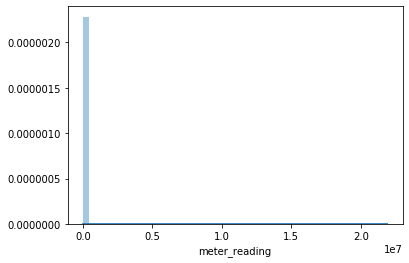

In [9]:
sns.distplot(train_df['meter_reading'])

🤔

In [51]:
n_train = train_df.shape[0]
n_zeros = train_df[train_df['meter_reading']==0]['meter_reading'].shape[0]
print(f'{n_zeros} zeros ({100*n_zeros/n_train:.2f}%)')

1873976 zeros (9.27%)


In [11]:
np.histogram(train_df['meter_reading'].values,bins=20)

(array([20213045,      153,      197,      125,      123,      355,
             422,      116,       58,       59,       34,       43,
             104,      177,      370,      165,      174,      249,
              95,       36]),
 array([       0.,  1095235.,  2190470.,  3285705.,  4380940.,  5476175.,
         6571410.,  7666645.,  8761880.,  9857115., 10952350., 12047585.,
        13142820., 14238055., 15333290., 16428525., 17523760., 18618995.,
        19714230., 20809465., 21904700.]))

In [53]:
# 99% of data below:
q_99 = train_df['meter_reading'].quantile(0.99)
print(q_99)

5449.22


### Veamos distribución

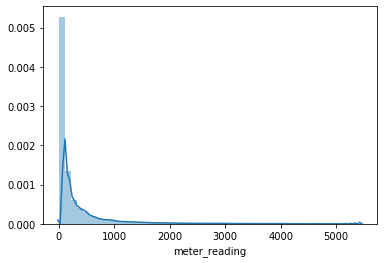

In [54]:
sns.distplot(train_df[train_df['meter_reading']<=q_99]['meter_reading'])

### Distribución si la transformamos con log1p

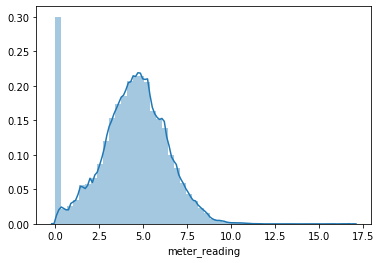

In [64]:
sns.distplot(np.log1p(train_df['meter_reading']))

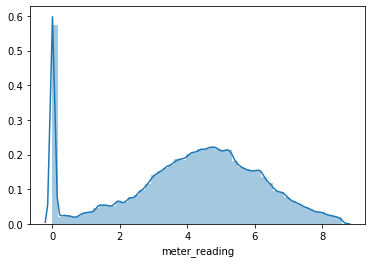

In [55]:
sns.distplot(np.log1p(train_df[train_df['meter_reading']<=q_99]['meter_reading']))

### Fechas

In [63]:
TS = 'timestamp'
print(f'Train from {train_df[TS].min()} to {train_df[TS].max()}')
print(f'Test  from { test_df[TS].min()} to { test_df[TS].max()}')

Train from 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Test  from 2017-01-01 00:00:00 to 2018-12-31 23:00:00


### Edificios

In [75]:
all_buildings = building_df['building_id'].values
print(f"Number of buildings: {len(all_buildings)}")

Number of buildings: 1449


In [72]:
train_buildings, test_buildings = np.unique(train_df['building_id'].values), np.unique(test_df['building_id'].values)

In [74]:
# SAME buildings in test and train
np.setdiff1d(all_buildings, train_buildings), np.setdiff1d(all_buildings, test_buildings)

(array([], dtype=int64), array([], dtype=int64))

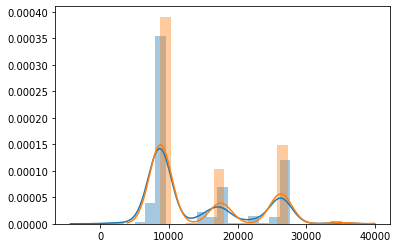

In [86]:
# home many observations per building
# train
train_samples_per_building = [len(g) for i,g in train_df.groupby('building_id')]
test_samples_per_building  = [len(g) for i,g in  test_df.groupby('building_id')]

sns.distplot(          train_samples_per_building)
sns.distplot(  np.array(test_samples_per_building)/2) # bc 2x samples in test

In [89]:
bid = np.argmin(train_samples_per_building)
display(train_df[train_df['building_id']==bid])
bid = np.argmax(train_samples_per_building) # 366*24*4
display(train_df[train_df['building_id']==bid])

,building_id,meter,timestamp,meter_reading
19085659,403,0,2016-12-12 01:00:00,44.35
19088023,403,0,2016-12-12 02:00:00,45.45
19090387,403,0,2016-12-12 03:00:00,44.82
19092751,403,0,2016-12-12 04:00:00,45.11
19095115,403,0,2016-12-12 05:00:00,44.73
19097478,403,0,2016-12-12 06:00:00,46.40
19099840,403,0,2016-12-12 07:00:00,53.90
19102203,403,0,2016-12-12 08:00:00,64.69
19104562,403,0,2016-12-12 09:00:00,77.52
19106915,403,0,2016-12-12 10:00:00,79.23


,building_id,meter,timestamp,meter_reading
1856,1249,0,2016-01-01 00:00:00,299.000
1857,1249,1,2016-01-01 00:00:00,695.555
1858,1249,2,2016-01-01 00:00:00,899.640
1859,1249,3,2016-01-01 00:00:00,840.861
4152,1249,0,2016-01-01 01:00:00,298.000
4153,1249,1,2016-01-01 01:00:00,830.408
4154,1249,2,2016-01-01 01:00:00,1019.590
4155,1249,3,2016-01-01 01:00:00,942.818
6448,1249,0,2016-01-01 02:00:00,299.000
6449,1249,1,2016-01-01 02:00:00,646.394


### Evolución por fecha

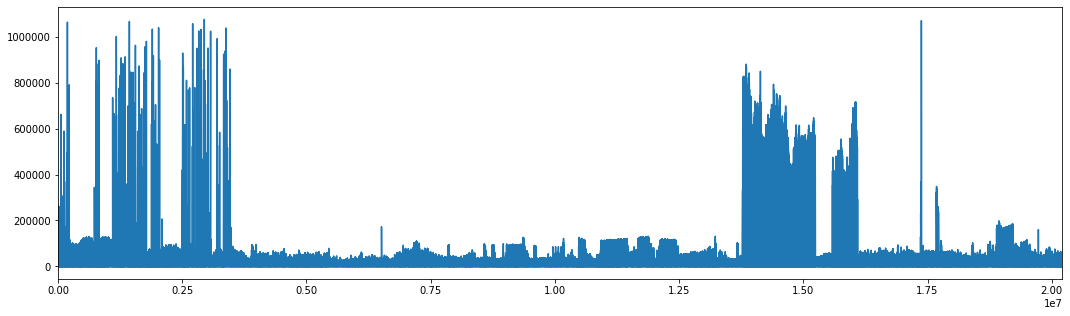

In [37]:
plt.figure(figsize = (18,5))
train_df_f['meter_reading'].plot()

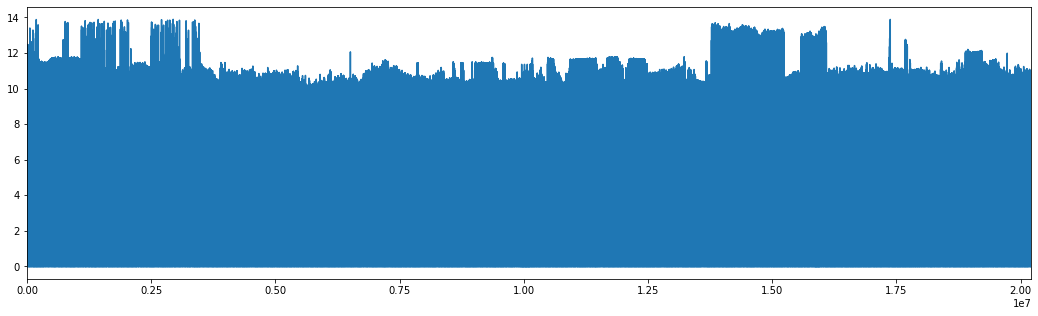

In [76]:
plt.figure(figsize = (18,5))
np.log1p(train_df_f['meter_reading']).plot()

In [ ]:
train

In [ ]:
del weather_train

In [ ]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = train["timestamp"].dt.hour
train["day"] = train["timestamp"].dt.day
train["weekend"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month

In [ ]:
train.drop('timestamp', axis=1, inplace=True)

## Making the DataBunch

Next, just like in fastai v1 we need to declare a few things. Specifically our Categorical and Continuous variables, our preprocessors (Normalization, Categorification, and FillMissing), along with how we want to split our data. `fastai` v2 now includes a `RandomSplitter` which is similar to `.split_by_rand_pct()` but now we can specify a custom range for our data (hence `range_of(train)`)

In [ ]:
cat_vars = ["building_id", "primary_use", "hour", "day", "weekend", "month", "meter"]
cont_vars = ["square_feet", "year_built", "air_temperature", "cloud_coverage",
              "dew_temperature"]
dep_var = 'meter_reading'

In [ ]:
procs = [Normalize, Categorify, FillMissing, Cuda]
splits = RandomSplitter()(range_of(train))

Now that those are defined, we can create a `TabularPandas` object by passing in our dataframe, the `procs`, our variables, what our `y` is, and how we want to split our data. `fastai` v2 is built on a Pipeline structure where first we dictate what we want to do, then we call the databunch (the high-level API is not done yet so we have nothing similar to directly DataBunching an object)

In [ ]:
to = TabularPandas(train, procs, cat_vars, cont_vars, y_names=dep_var, splits=splits, is_y_cat=False)

If we look at what `to` actually is, we can see what looks to be a bunch of batches of our data aligned into a dataframe that can easily be read!

In [ ]:
to

We can then also easily look at our training and validation datasets by calling `.train` or `.valid`

In [ ]:
to.train

From here we can create our DataBunch object one of two ways. We can either directly do a `dbch = to.databunch()`, *or* we can take it one step further and apply custom works to some dataloaders. First let's look at the basic version

In [ ]:
dbch = to.databunch()
dbch.valid_dl.show_batch()

In [ ]:
is_categorical_dtype(to.meter_reading)

In [ ]:
next(iter(dbch.train_dl))

Now let's try doing this the second method. We can increase our batch size since the validation set is much smaller than our training dataset. We can also specify a few options with our training dataset too. To do this, we will need to create `TabDataLoaders` to, well, load the data!

We pass in a dataset, a batch size, our `num_workers`, along with if we want to shuffle our dataset and drop the last batch if it does not evenly split. You should always want to do this with the **training** dataset but not the validation. Defaultly they are both set to `False`

In [ ]:
trn_dl = TabDataLoader(to.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=128)

Lastly we can create a `DataBunch` object by calling `DataBunch()` and passing in our two `DataLoaders`

In [ ]:
dbunch = DataBunch(trn_dl, val_dl)
dbunch.valid_dl.show_batch()

As you can see there are a *lot* of ways we can customize our DataBunch's now

## Training the Model

First we need to create a `TabularModel` that needs an embedding matrix size, how many continuous variables to expect, the number of possible outputs (classes), and how big we want our layers. To pass in the embedding matrix sizes, we can use `get_emb_sz` onto a `TabularPandas` object

First let's define our embedding size rule of thumb, along with our `get_emb_sz` function

In [ ]:
def emb_sz_rule(n_cat): 
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

In [ ]:
def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

In [ ]:
def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.procs.classes, n, sz_dict) for n in to.cat_names]

Now we pass in our `TabularPandas` object, `to`

In [ ]:
emb_szs = get_emb_sz(to); print(emb_szs)

The last piece of the puzzle we need is our basic `TabularModel`

In [ ]:
class TabularModel(Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0., y_range=None, use_bn=True, bn_final=False):
        ps = ifnone(ps, [0]*len(layers))
        if not is_listy(ps): ps = [ps]*len(layers)
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz]
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [BnDropLin(sizes[i], sizes[i+1], bn=use_bn and i!=0, p=p, act=a)
                       for i,(p,a) in enumerate(zip([0.]+ps,actns))]
        if bn_final: _layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*_layers)
    
    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

If you noticed, most of what changed with the v2 API is focused on the dataloading / DataBunch creation. The rest of this Kernel sould look very familiar to fastai users

In [ ]:
model = TabularModel(emb_szs, len(to.cont_names), 1, [1000,500], y_range=(0,15)); model

Now we can define our optimization function and create our `Learner`

In [ ]:
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dbunch, model, MSELossFlat(), opt_func=opt_func)

In [ ]:
dbunch.train_dl.bs = 1024*4

In [ ]:
learn.fit_one_cycle(5)

I need to solve the bug for why we are not fitting properly, but this is also just a subset of the data. Hope this helps you get started! :)

- muellerzr

In [ ]:
p = learn.get_preds()

In [ ]:
p.shape